<img src="./img/HWNI_logo.svg"/>

# Lab 10 - Model Accuracy and Reliability

In [1]:
%matplotlib inline

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import scipy.stats

# choose colors that work for most color-blind folks
sns.set_palette("colorblind")
sns.set(color_codes=True)

import util.lab10utils as utils

from ipywidgets import interact,interactive, fixed, interact_manual

utils.formatDataframes()

## Model Accuracy

In the previous lab, we learned how to fit our models. In general, we find the parameters that give us the best performance on some cost function, usually negative log-likelihood.

But fitting models only allows us to optimize this cost function once a model has been specified -- once a family of models has been chosen, whether it's the linear family, or a linearized or parametric nonlinear family with fixed nonlinearities. How can we compare models from different families?

We could just use the performance on the cost function, but then we won't have any absolute sense of how good the model is. That is, is a loss of 10 bits on the negative log-likelihood good? What about 1000 bits? We can say 10 bits is better than 1000, but we don't know whether a stupid, simple model would score 1 bit or 1,000,000 bits. The same is true of squared error.

### Defining a Measure of Model Accuracy

The trick is to normalize the model accuracy using a baseline. 

$$
    \frac{\text{Fitted Model Performance}}{\text{Baseline Model Performance}}
$$

For models that use squared error as their loss, the right baseline is a model that ignores the inputs $X$ and always predicts the average value of the output variable $Y$. 

$$
    \frac{\text{Fitted Model Mean Squared Error}}{\text{"Predict the Mean" Model Mean Squared Error}}
$$

The average of the squared difference of $X$ from its average value is just the *variance* of $X$. The mean squared error is the variance of the residuals, or errors, so we can rewrite the above as:

$$
    \frac{\text{Variance of Errors}}{\text{Variance of}\ Y}
$$

This is sometimes called the *unexplained variance*, or more accurately, the *fraction of unexplained variance*. Beware that this interpretation really only makes sense when the variance of the errors is less than the variance of $Y$.

This is a perfectly good metric, but it goes down (towards a minimum of 0) when the model gets better. We'd prefer it to increase as our model gets better. We can do this by putting a negative sign in front. 

$$
    -\frac{\text{Variance of Errors}}{\text{Variance of}\ Y}
$$

But now all the models get a negative score. This is also "not nice", so we add 1 to our number.

$$
    1-\frac{\text{Variance of Errors}}{\text{Variance of}\ Y}
$$

This is what we were looking for: a measure of how good our model is that 1) has a meaningful zero point, 2) tops out at 1, and 3) decreases when the model gets worse. We call it $R^2$.

$$
    R^2 = 1-\frac{\text{Variance of Errors}}{\text{Variance of}\ Y}
$$

It is also known as the *coefficient of determination*. Because it is one minus the fraction of unexplained variance, it is sometimes called the *explained variance* or the *fraction of variance explained*, but this interpretation only works when $R^2$ is non-negative.

Some are even more finicky and prefer percents to fractions, so they multiply by 100.

### Issues with $R^2$

Our goal in defining $R^2$ was to create a measure of model accuracy that would let us choose between models. Unfortunately, the definition of $R^2$ above is insufficient for this purpose.

The key reason for this is that what we have is a $R^2$ value for our sample, but what we'd really like to know is the value of $R^2$ for the entire population. From another perspective, we'd like to know what kind of $R^2$ value we'll get if we apply our model on new samples, but we only have an $R^2$ value for our model on one sample.

We've seen this problem before; in fact, it's the central problem of statistics. In some cases, we can prove that the value of a statistic that we calculate from a random sample is, on average, equal to the value of some statistic on the whole population. When we can prove this, we call the statistic an *unbiased estimator* of the underlying quantity. Unbiased estimators neither over-estimate nor under-estimate, on average, the true value.

Examples of unbiased estimators include the sample mean for the population mean, the sample median for the population median, and the "$n-1$" formula for calculating the sample variance or sample standard deviation for the population variance or population standard deviation.

#### Q1 What's an example of a biased estimator? Is it easier to come up with biased or unbiased estimators?

<font color="1874CD"> <b> 

Some examples:
1. Calculate the mean and add 1.
1. Always predict 2.
1. Calculate the variance using $n$ degrees of freedom instead of $n-1$.

There are far more biased than unbiased estimators. Such is life.

Unfortunately, the $R^2$ on the sample is a *biased* estimator of the $R^2$ on the population. It tends to over-estimate its value. This is bad in part because it will tend to make us overly confident in the performance of our models.

Worse still, the bias of $R^2$ is not the same across models and datasets. It tends to be more biased for models with more parameters, when the noise is high, and when the number of datapoints is low. We'll examine this bias below, but first we'll try to correct it.

### Cross-Validation to the Rescue!

We'd like to be able to construct an unbiased estimator for $R^2$. Unfortunately, this cannot be done.

Instead, we construct a biased estimator whose bias isn't connected with the number of parameters in the model. This estimator is obtained via *cross-validation*. It has a bias towards *under-estimating* the value of $R^2$ on the population.

In the most common form of cross-validation, *hold-out* cross-validation, we fit a model to a subset of our data and then calculate $R^2$ on the data that was left out. In another form of cross-validation, *k-fold* cross-validation, we split the data into *k* pieces and fit separate models to subsets made out of *k-1* pieces. We then take the predictions of each model on its held out piece and use those as our model predictions when calculating $R^2$.

*k*-fold cross-validation is more accurate (less variable across samples) than hold-out cross-validation, but it takes longer -- you have to fit *k* models, instead of just one. When the size of the chunks in *k*-fold cross-validation is smaller than the size of the hold-out set in hold-out cross-validation, it is also less biased. If *k* is equal to *n*, the size of the data set, we call this *leave-one-out* cross-validation. It is the most accurate and least biased estimator of $R^2$, but it requires you to fit *n* models. If fitting one model takes a day and you have a dataset size of 10,000 or one million, this is obviously impractical.

Where does the bias in cross-validation come from? It comes from the fact that the model is prevented from seeing all of the data. A model fit on more of the data will do a better job, on average, than a model fit on less of the data. Therefore the full model's $R^2$ on the population will, on average, be higher than the $R^2$ on the population of a model fit on a subset of the data. But cross-validation is an unbiased estimator of the latter, so it must be a biased estimator of the former.

#### Q2 Explain why this makes *k*-fold cross-validation less biased the larger *k* is.

<font color="1874CD"> <b> 
When *k* is larger, the chunks removed from the data are smaller. This means that the dataset provided to the cross-validation models is closer to the size of the full dataset. The difference in sizes between these two sets is what gives rise to bias, so increasing *k* reduces bias.

### Using $R^2$ to Compare Polynomial Models

The cell below will generate data from a linearized polynomial model with degree given by `trueDegree`. It will then draw a sample of size `sampleSize` from the population and fit linearized models with degrees ranging from `minDegree` to `maxDegree`.

One example of the result of this sample-and-fit procedure will be plotted as a scatter plot with the population in transparent blue and the sample in black, the model predictions of models with varying degrees as thin, colored lines, and the true model as a thick blue line.

For each model, $R^2$ is calculated on the sample, using leave-one-out cross-validation, and on the entire population. Note that, just like the mean, each of these $R^2$ values is a statistic and so will be different depending on the sample. To get an accurate estimate, multiple samples are drawn, with the total number set by `numExperiments`.

Run the cell below and answer the following questions.

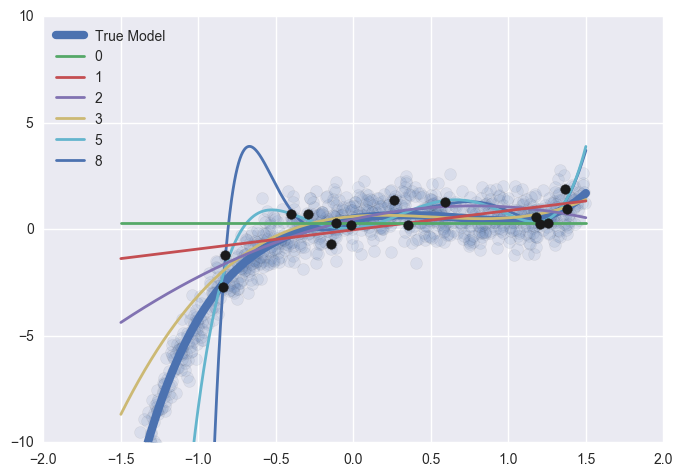

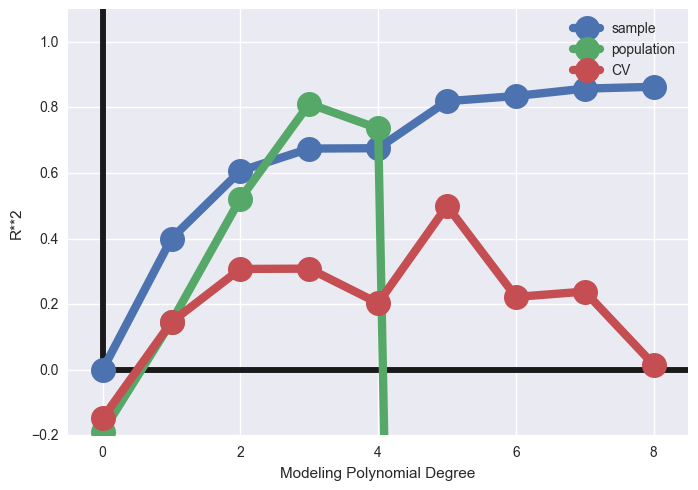

In [8]:
minDegree = 0
trueDegree = 5
maxDegree = 8

fitted,actual,cross_validated = utils.runSimulation(trueDegree,minDegree=minDegree,
                                              maxDegree=maxDegree,sampleSize=15,
                                             numExperiments=1,)

utils.plotResults(fitted,actual,cross_validated,minDegree=minDegree,maxDegree=maxDegree)

#### Q3 In general, is there an order to the values of $R^2$ on the sample, population, and via cross-validation? That is, do we find that one is consistently higher or lower, for a given degree, than the others? Can you explain why or why not?

<font color="1874CD"> <b> 

Yes. $R^2_{fitted}\ >\ R^2_{actual}\ >\ R^2_{CV}$.

$R^2_{fitted}$ is biased upwards and $R^2_{CV}$ is biased downwards.

#### Q4 Why can the $R^2$ be less than 0? Why are the population and cross-validated $R^2$ always less than 0 for the degree-0 polynomial model? Hint: what does a degree-0 polynomial look like?

<font color="1874CD"> <b>

If the residuals have greater variance than the original variable, then $R^2$ can be less than 0. This happens when the fitted model is worse than a model that just predicts the average value of $Y$.

For the degree-0 polynomial model, we're restricted to only considering models that have constant predictions. The best model in this class is the baseline model, so the maximum value of $R^2$ for models in this family is actually 0.

#### Q5 Why does the $R^2$ on the sample get closer to 1 as the degree goes up? Consider the example experiment that is plotted first. What do these high-degree models look like?

<font color="1874CD"> <b> 

As the degree increases, the model gets more flexible. This allows it to fit the exact values of the data points in the sample.

We can see this in the high-degree models plotted in the example experiment. They very closely match the sample points, but away from the sample points, they oscillate wildly.

The y-axes are clipped so that negative values less than -0.2 are not plotted. 

#### Q6 Why are the cross-validation-obtained and actual values of $R^2$ so negative for the high-degree polynomial models?

<font color="1874CD"> <b> 

The high-degree models are wildly inaccurate away from the sample points -- as they get better at fitting the sample points, they get worse almost without bound away from those points. This gives a terrible $R^2$ for left-out sample points when it comes time for cross-validation and a similarly bad $R^2$ for other points from the population.

Set `trueDegree = 3`.

#### Q7 Does cross-validation $R^2$ always peak at the true degree? Explain why this is the case.

<font color="1874CD"> <b> 

Not always. The data doesn't always provide sufficient evidence to robustly determine the 4 parameters of a 3rd-degree polynomial, so a 2nd-degree model, which has fewer parameters, sometimes generalizes better than a 3rd-degree model, even though it's not the "true" model.

#### Q8 Does the $R^2$ on the population always peak at the true degree? What does/would it mean for this true $R^2$ to not have its peak value at the true degree?

<font color="1874CD"> <b> 

It peaks at the correct value more frequently, but not always. This means that sometimes there isn't enough evidence in the entire population to distinguish between a 2nd-degree and a 3rd-degree polynomial model.

#### Q9 Increase the sample size by an order of magnitude. What happens to the $R^2$ curves? Connect this answer with your answer to the previous question.

<font color="1874CD"> <b> 

They all become very similar. There may be a slight peak around 2 or 3 degrees, but the cross-validation procedure now no longer provides strong evidence for picking a lower-degree model. The higher-degree models are able to find a fairly accurate model using the larger sample.

Reduce the `numExperiments` to 1 and return the sample size to `15`.

#### Q10  What happens? Why?

<font color="1874CD"> <b> 

The neat patterns that we saw above are no longer present. $R^2$ is a statistic, so it is random and dependent on the sample. Depending on the sample, the patterns we noticed above may or may not hold. This becomes less true as we increase the sample size.

## Model Reliability

Recall that a statistic is anything we calculate from our data -- the result of applying a function to our data. In this view, the parameters we calculate from model-fitting are themselves statistics: they are random (usually only because our samples are random) and so have a distribution (aka the sampling distribution). The only difference between the model-fit parameters and more traditional statistics, like the mean or the standard deviation, is that the function involved is a lot more complicated!

As with any statistic, we'd like to know the sampling distribution of our parameters. If this distribution is tight, then we have reason to believe that we have found a decently correct model of the data, perhaps even the true model. If the distribution is loose, then our model, even if it is accurate, is likely to be incorrect. At the very least, we can say that a model with a tight distribution of its parameters isn't strongly affected by the randomness of the data, and so we call it a *reliable* model. When a model is reliable, we expect to find roughly the same parameter values if we re-sample our data from the population and fit again.

Unfortunately, the complicatedness of the function we use to generate our parameters from our data (the killer part is the $\arg\!\min$) means there are, in general, not neat formulas or simple distributions, as we had for estimating the sampling distribution of, say, the mean and standard deviation of independent Gaussian variables.

### Bootstrapping to the Rescue!

Luckily, there's a method that works to estimate sampling distributions without assuming almost anything about the population distribution. This method is *bootstrapping*. 

To use bootstrapping to estimate the sampling distribution of the parameters of a model, we first use the data's empirical distribution as an estimate of the true distribution. We then sample from that empirical distribution to approximate sampling from the true distribution. Sampling from an empirical distribution takes the form of sampling, with replacement, from the data. We then fit the model to each sample. 

The empirical distribution of parameter values obtained by repeatedly fitting the model to bootstrapped samples is taken as an estimate of the true sampling distribution of those parameter values. We can use this distribution to make judgments about the reliability and likely correctness of our model.

### Bootstrapping and Model Reliability with Seaborn

Because bootstrapping is simple to implement and relatively assumption-free, seaborn will do bootstrapping as part of its regression process unless you ask it not to. It then plots a confidence interval for the model predictions at each point -- that is, at each value of $X$, it draws a transparent, colored stripe that covers the predictions of confidence level % of the bootstrapped models.

The function for linear and linearized modeling in seaborn is `sns.lmplot`. The argument `order` tells it what degree, or order, of polynomial model to use to fit the data. Linear modeling is `order=1`. The argument `ci` determines the confidence level to draw the confidence intervals at -- the default is `95`.

The cell below will generate `N` datapoints from a linear model with slope and offset parameters `w` and `b` and then perform a linear or linearized regression using `lmplot`. Use it to answer the following questions.

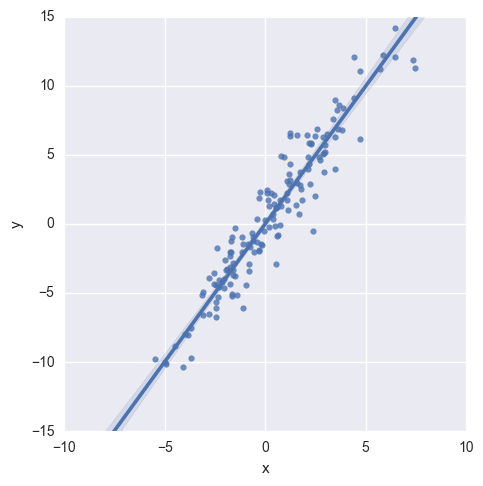

In [14]:
N = 150
gaussianNoise = True
w = 2; b = 0

df = utils.setupLinearModel(N,gaussianNoise=gaussianNoise,
                     slope=w,offset=b)

sns.lmplot(data=df,x='x',y='y',
           order=1,ci=95);
utils.clean_lmplot()

## robust regression

# sns.lmplot(data=df,x='x',y='y',robust=True,ci=95);
# utils.clean_lmplot()

#### Q11 Compare the reliability of linear regression to increasing orders of polynomial regression.

<font color="1874CD"> <b> 

Linear regression is more reliable. Higher order polynomial models are less reliable.

#### Q12 Increase N to 500, and again compare linear regression to increasing order of polynomial regression. What happens to reliability? Compare the area where data is dense to area where data is sparse.

<font color="1874CD"> <b>

The reliability of the polynomial models goes up, but only in areas where the data is dense. Linear models remain reliable well outside of the data range.

Set `order` to `1`, and `N` to `25`. The Boolean variable `gaussianNoise` toggles between a model with Gaussian noise (`True`) and a model with a more outlier-prone noise distribution.

#### Q13 How does reliability change in the presence of outliers? 

<font color="1874CD"> <b>

Reliability goes down -- way down, if there are lots of outliers.

Increase `N` to `500`.

#### Q14 Are outliers still an issue? 

<font color="1874CD"> <b>

Usually.

Make sure to run the cell multiple times. 

#### Q15 Is your answer different on different runs? Why is this?

<font color="1874CD"> <b>

Yes -- sometimes the reliability is terrible, due to gnarly outliers, but sometimes the outliers aren't so bad and the reliability is good.

Robust regression tries to get around the problem of outliers. The final two, initially-commented, lines of the above code cell will run robust regression on data.

#### Q16 Compare the reliability of linear and robust regression on datasets of size `N=10` and `N=50`.

<font color="1874CD"> <b>

Robust regression is much more reliable in the presence of outliers.

## Accuracy Meets Reliability

Accuracy and reliability are closely related. We measure accuracy by fitting the model to data it has never seen before (simulating a sample from the population) and we measure reliability by fitting the model to simulated samples from the population. A reliable model can be either accurate or inaccurate, but an accurate model will almost always be reliable.

Reliable and accurate models are what we hope for. If multiple models of the same data are both accurate and reliable, the data provides equal evidence for all of them. If we want to pick one, we usually rely on a form of Occam's Razor: the simplest model that is accurate and reliable is the best.

Reliable and inaccurate models arise when our model family is too limited to include an accurate model. For example, we could be fitting a linear model to quadratic or parametric nonlinear data. Our fitting procedure consistently finds the same solution when presented with new data, but this solution is not close to the true model.

Unreliable and inaccurate models arise when there is too much noise or too little data to fit a good model. On the side of reliability, a large ratio of noise to data quantity means that samples are more likely to look different from each other, and so be described by models with different parameters. On the side of accuracy, a large ratio of noise to data means that there's less evidence for the true relationship in the data.

Increasing the number of parameters effectively reduces the amount of data. Increasing the number of parameters too much for the level of noise and the size of the dataset results in models that are unreliable and inaccurate, but nevertheless do a good job describing the data on which they were trained. These models are called *over-fit* models.

It is only infrequently the case that a model is both accurate and unreliable. For this to be the case, the full sample used to train the model must be similar enough to the population that fitting uncovers parameters that give a good fit to the population, but re-sampling from the population (e.g. by bootstrapping) results in wildly different models each time. This in general only occurs by chance, not due to deterministic factors, like choice of model family or noise level, as in the other three cases. If the data has outliers, but you don't take this into account in your model, this becomes slightly more likely. 

### Looking at Accuracy and Reliability Simultaneously

The code cell below does much the same as code cell above -- generates data from a linear model, fits it, etc. -- but it also plots the true model so that we can get a sense of the model accuracy.

#### Q17 How do we determine accuracy here?

<font color="1874CD"> <b>

We check how close the regression line is to the true model.

Use this code cell to answer the following questions.

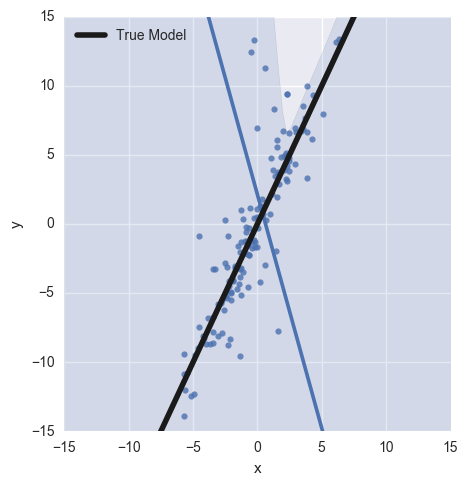

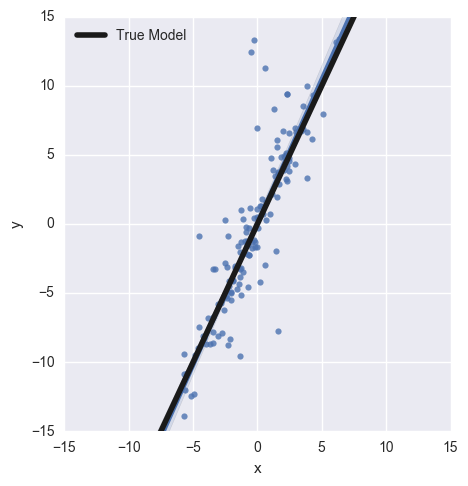

In [17]:
N = 150
gaussianNoise = False
w = 2; b = 0

df = utils.setupLinearModel(N,gaussianNoise=gaussianNoise)

sns.lmplot(data=df,x='x',y='y',order=1,ci=95);
utils.clean_lmplot()
utils.plotTrueModel(w,b)

## robust regression

sns.lmplot(data=df,x='x',y='y',robust=True,ci=95);
utils.clean_lmplot()
utils.plotTrueModel(w,b)

#### Q 18 How accurate and reliable are polynomial models in regions where the data is dense? What about outside of this region? 

<font color="1874CD"> <b>

Polynomial models are, in general, neither accurate nor reliable in either region, though things get worse away from the data.

#### Q 19 Increase N to 100. Does this change your answer?

<font color="1874CD"> <b>

Polynomial models become accurate and reliable within the data region, but remain inaccurate and unreliable outside it.

#### Q 20 What does this say about using complicated models trained on large datasets? If you know the concept of "generalization", it might be useful here.

<font color="1874CD"> <b>

When using a complicated model on a large dataset, you're likely to be able to accurately and reliably determine the model in regions where there is a lot of data -- and you'll be able to generalize between these datapoints. However, you'll have trouble generalizing to regions where data is sparse.

Again compare linear and increasing orders of polynomial regression, but now with `N = 100` and non-Gaussian noise. 

#### Q 21 Which models are more accurate and reliable in the presence of outliers?

<font color="1874CD"> <b>

Linear models are a bit more accurate and certainly more reliable.

Increase `N` to 1000.

#### Q 22  Have the issues with outliers gone away? Compare higher-order polynomial and linear regression.

<font color="1874CD"> <b>

Not entirely. The improvement is better for linear models.

Using non-Gaussian noise, compare linear with robust regression. 

#### Q23 What happens to accuracy and reliability?

<font color="1874CD"> <b>

Robust regression is much more accurate and reliable.

Robust regression is "strangely unpopular" in the eyes of many statisticians. 

#### Q24 Based on your experiences above, can you explain both why it should be used and why people don't use it much?

<font color="1874CD"> <b>

It's very slow, even on small datasets. It's also much harder to explain and to understand than other regression methods.